# Sesión 5 - Implementación de algoritmos DQN y PG

> En la presente sesión, se va a desarrollar la **implementación** de los algoritmos básicos de aprendizaje por refuerzo: **Deep Q-networks (DQN)**, y **Policy Gradients (PG)**. El caso de uso desarrollado consistirá en el **Atary**, cuyo **entorno** es modelado por la librería de acceso público de **OpenAI gym**. Se hará uso de dos librería para la implementación de algoritmos de aprendizaje por refuerzo: **keras-rl** y **pytorch**. La primera, de más alto nivel, servirá para establecer un conocimiento práctico de los métodos DQN, y analizar los distintos hiperparámetros de entrenamiento. En el segundo caso, PG será implemetado con pytorch, librería de más bajo nivel, y la cuál permitirá trabajar en detalle la estrategia de aprendizaje on-policy y la optimización por gradiente de la policy.






---
## **PARTE 1** - Instalación y requisitos previos

> Las prácticas han sido preparadas para poder realizarse en el entorno de trabajo de Google Colab. Sin embargo, esta plataforma presenta ciertas incompatibilidades a la hora de visualizar la renderización en gym. Por ello, para obtener estas visualizaciones, se deberá trasladar el entorno de trabajo a local. Por ello, el presente dosier presenta instrucciones para poder trabajar en ambos entornos. Siga los siguientes pasos para un correcto funcionamiento:
1.   **LOCAL:** Preparar el enviroment, siguiendo las intrucciones detalladas en la sección *1.1.Preparar enviroment*.
2.  **AMBOS:** Modificar las variables "mount" y "drive_mount" a la carpeta de trabajo en drive en el caso de estar en Colab, y ejecturar la celda *1.2.Localizar entorno de trabajo*.
3. **COLAB:** se deberá ejecutar las celdas correspondientes al montaje de la carpeta de trabajo en Drive. Esta corresponde a la sección *1.3.Montar carpeta de datos local*.
4.  **AMBOS:** Instalar las librerías necesarias, siguiendo la sección *1.4.Instalar librerías necesarias*.



---
### 1.1. Preparar enviroment (solo local)



> Para preparar el entorno de trabajo en local, se han seguido los siguientes pasos:
1. En Windows, puede ser necesario instalar las C++ Build Tools. Para ello, siga los siguientes pasos: https://towardsdatascience.com/how-to-install-openai-gym-in-a-windows-environment-338969e24d30.
2. Instalar Anaconda
3. Siguiendo el código que se presenta comentado en la próxima celda: Crear un enviroment, cambiar la ruta de trabajo, e instalar librerías básicas.


```
conda update --all
conda create --name miar_rl python=3.8
conda activate miar_rl
cd "PATH_TO_FOLDER"
conda install git
pip install jupyter
```


4. Abrir la notebook con *jupyter-notebook*.



```
jupyter-notebook
```




---
### 1.2. Localizar entorno de trabajo: Google colab o local

In [1]:
# ATENCIÓN!! Modificar ruta relativa a la práctica si es distinta (drive_root)
mount='/content/gdrive'
drive_root = mount + "/My Drive/08_MIAR/sesiones_practicas/sesion_practica_1"

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

---
### 1.3. Montar carpeta de datos local (solo Colab)

In [2]:
# Switch to the directory on the Google Drive that you want to use
import os
if IN_COLAB:
  print("We're running Colab")

  if IN_COLAB:
    # Mount the Google Drive at mount
    print("Colab: mounting Google drive on ", mount)

    drive.mount(mount)

    # Create drive_root if it doesn't exist
    create_drive_root = True
    if create_drive_root:
      print("\nColab: making sure ", drive_root, " exists.")
      os.makedirs(drive_root, exist_ok=True)

    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root
# Verify we're in the correct working directory
%pwd
print("Archivos en el directorio: ")
print(os.listdir())

Archivos en el directorio: 
['08MIAR_dqn.ipynb', '08MIAR_dqn_pg - Clase.ipynb', '08MIAR_vanilla_pg.ipynb', 'images.zip']


---
### 1.4. Instalar librerías necesarias


In [3]:
# if IN_COLAB:
#   %pip install gym==0.17.3
#   %pip install git+https://github.com/Kojoley/atari-py.git
#   %pip install keras-rl2==1.0.5
#   %pip install tensorflow==2.8
# else:
#   %pip install gym==0.17.3
#   %pip install git+https://github.com/Kojoley/atari-py.git
#   %pip install pyglet==1.5.0
#   %pip install h5py==3.1.0
#   %pip install Pillow==9.5.0
#   %pip install keras-rl2==1.0.5
#   %pip install Keras==2.2.4
#   %pip install tensorflow==2.5.3
#   %pip install torch==2.0.1
#   %pip install agents==1.4.0

---
### 1.5.Acerca de las librerías para RL

Librería para trabajar con nuestros entornos: gym (https://gym.openai.com/) \
Librería para trabajar con deep learning: tensorflow (https://www.tensorflow.org/) \
Librería para desarrollar soluciones de RL a alto nivel: keras-rl (https://github.com/keras-rl/keras-rl) \


---
## **PARTE 2** - *Deep Q-learning*


---
### 2.1. DQN Pseudo-código

In [1]:
# from IPython import display
# display.Image("images/dqn.png", width = 600, height = 300)

---
### 2.2. Ejemplo de DQN with keras-rl - CartPole

¿Quieres intentar estabilizar el péndulo invertido tu?
https://jeffjar.me/cartpole.html

Información del entorno:
https://www.gymlibrary.dev/environments/classic_control/cart_pole/

Basado en: https://github.com/keras-rl/keras-rl/blob/master/examples/dqn_cartpole.py

In [1]:
import numpy as np
import gym

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory                    # liberar memoria

In [5]:
ENV_NAME = 'CartPole-v0'  # el nombre del enviroment

# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

In [7]:
# nos movemos a la izquierda o a la derecha
print("Numero de acciones disponibles:" + str(nb_actions))

Numero de acciones disponibles:2


In [8]:
# aqui la información ya esta pre procesada por lo que cojemos directamente la observacion
print("Formato de las observaciones:")
env.observation_space

# nos dicen el maximo y minimo de lo valores, cuantos hay y el tipo de dato

Formato de las observaciones:


Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)

In [9]:
# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))     # lineal por que queremos valores numericos que no deben estar acotados 
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4)                 0         
_________________________________________________________________
dense (Dense)                (None, 16)                80        
_________________________________________________________________
activation (Activation)      (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0

### se define la memoria



In [10]:
# Let's define the memory for storing the experience
memory = SequentialMemory(limit=50000, window_length=1)

### se define la policy

postprocesado de la función q para obtener pseudo probabilidades

- Recompensa esperada a futuro: $Q(s, a) = [10, 40, 0 ]$
- una policy voraz: $a \rightarrow [0, 1, 0]$
- boltzmanQPolicy: $Q(s,a)/sum(Q(s, a)) \rightarrow [20/60, 40/60, 0 ] + sampling [1, 0, 0]$

In [11]:
# Define the policy that our agent will follow
policy = BoltzmannQPolicy()

### definición del agente y compilación

La exploración tiene dos parte; en la primera seguimos una estrategia aleatoria ( exploración ), y después seguimos casi siempre la policy aprendida por el agente en esa exploración (explotación)

In [12]:
# Define the agent
dqn = DQNAgent(model=model,              # le pasamos el modelo
               nb_actions=nb_actions,    # 
               memory=memory,            # la memoria
               nb_steps_warmup=10,       #
               target_model_update=1e-2, # cada que porcentaje del entrenamiento vamos a actualizar el target
               policy=policy)            # le indicamos nuestra policy

dqn.compile(Adam(learning_rate=1e-3), 
            metrics=['mae'])

In [13]:
# Train the agent
dqn.fit(env, nb_steps=50000, visualize=False, verbose=2)

# After training is done, we save the final weights.
dqn.save_weights('dqn_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

Training for 50000 steps ...


c:\Users\plane\miniconda3\envs\venv_RL\lib\site-packages\tensorflow\python\keras\engine\training.py:2424: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
c:\Users\plane\miniconda3\envs\venv_RL\lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


    26/50000: episode: 1, duration: 2.884s, episode steps:  26, steps per second:   9, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.538 [0.000, 1.000],  loss: 0.482933, mae: 0.504232, mean_q: 0.013995


c:\Users\plane\miniconda3\envs\venv_RL\lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


    60/50000: episode: 2, duration: 0.464s, episode steps:  34, steps per second:  73, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.618 [0.000, 1.000],  loss: 0.437940, mae: 0.493503, mean_q: 0.085422
    81/50000: episode: 3, duration: 0.274s, episode steps:  21, steps per second:  77, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.524 [0.000, 1.000],  loss: 0.360557, mae: 0.485162, mean_q: 0.213511
   132/50000: episode: 4, duration: 0.627s, episode steps:  51, steps per second:  81, episode reward: 51.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.588 [0.000, 1.000],  loss: 0.159280, mae: 0.531777, mean_q: 0.751043
   142/50000: episode: 5, duration: 0.133s, episode steps:  10, steps per second:  75, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.800 [0.000, 1.000],  loss: 0.046615, mae: 0.678835, mean_q: 1.186736
   159/50000: episode: 6, duration: 0.224s, episode steps:  17, step

In [14]:
# Finally, evaluate our algorithm for 5 episodes.
dqn.load_weights('dqn_{}_weights.h5f'.format(ENV_NAME))
dqn.test(env, nb_episodes=10, visualize=True)
env.close()


Testing for 10 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200


---
### 2.3. Ejemplo DQN con Keras-rl - Breakout

Información del entorno: https://www.gymlibrary.dev/environments/atari/breakout/

Basado en: https://github.com/Finspire13/pytorch-policy-gradient-example/blob/master/pg.py

In [1]:
from __future__ import division

from PIL import Image
import numpy as np
import gym

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Convolution2D, Permute
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

In [2]:
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

In [11]:
# In this example, we need to preprocess the observations
class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')

    def process_state_batch(self, batch):
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

In [12]:
# Get the environment and extract the number of actions.
import gym
import numpy as np
env_name = 'BreakoutDeterministic-v4'
env = gym.make(env_name)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

In [13]:
print("Numero de acciones disponibles: " + str(nb_actions))

Numero de acciones disponibles: 4


In [14]:
print("Formato de las observaciones:")
env.observation_space

Formato de las observaciones:


Box(0, 255, (210, 160, 3), uint8)

In [15]:
# Next, we build our model. We use the same model that was described by Mnih et al. (2015).
input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE
model = Sequential()
print(K.image_data_format())
if K.image_data_format() == 'channels_last':
    # (width, height, channels)
    model.add(Permute((2, 3, 1), input_shape=input_shape))
elif K.image_data_format() == 'channels_first':
    # (channels, width, height)
    model.add(Permute((1, 2, 3), input_shape=input_shape))
else:
    raise RuntimeError('Unknown image_dim_ordering.')
# se podria sustituir el stride alto por capas de pooling
model.add(Convolution2D(32, (8, 8), strides=(4, 4)))
model.add(Activation('relu'))
model.add(Convolution2D(64, (4, 4), strides=(2, 2)))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), strides=(1, 1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

channels_last
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 32)        8224      
_________________________________________________________________
activation_5 (Activation)    (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
activation_6 (Activation)    (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
activation_7 (Activation)    (None, 7, 7

In [16]:
memory = SequentialMemory(limit=1000000,    # memoria muy grande 
                          window_length=WINDOW_LENGTH) # 4
processor = AtariProcessor()  # creamos la instancia de preprocesamiento

In [17]:
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(),  # definimos la policy
                              attr='eps',          # pero con un scheduler
                              value_max=1.,        # empiezaa en 1
                              value_min=.1,        # termina en 0.1 en el ultimo step
                              value_test=.05,      # en testeo será de 0.05
                              nb_steps=1000000)    #

In [18]:
dqn = DQNAgent(model=model, 
               nb_actions=nb_actions, 
               policy=policy,
               memory=memory, 
               processor=processor,
               nb_steps_warmup=50000,      # tenemos experience replay
               gamma=.99,                  # el discount reward
               target_model_update=10000,  # cada 10000 itereaciones se actualiza se actualiza el modelo
               train_interval=4)           # cada cuantas iteraciones se hace un step de entrenaminto

dqn.compile(Adam(learning_rate=.00025), metrics=['mae'])

In [19]:
# Training part
weights_filename = 'dqn_{}_weights.h5f'.format(env_name)
checkpoint_weights_filename = 'dqn_' + env_name + '_weights_{step}.h5f'
log_filename = 'dqn_{}_log.json'.format(env_name)
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=25000)]

callbacks += [FileLogger(log_filename, interval=100)]

dqn.fit(env, 
        callbacks=callbacks, 
        nb_steps=1750000, 
        log_interval=10000, 
        visualize=False)

dqn.save_weights(weights_filename, overwrite=True)

Training for 1750000 steps ...
Interval 1 (0 steps performed)


c:\Users\plane\miniconda3\envs\venv_RL\lib\site-packages\tensorflow\python\keras\engine\training.py:2424: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


 1698/10000 [====>.........................] - ETA: 45s - reward: 0.0053done, took 12.025 seconds


In [1]:
# Testing part
#weights_filename = 'dqn_{}_weights.h5f'.format(env_name)
weights_filename = "dqn_BreakoutDeterministic-v4_weights_1750000.h5f"
dqn.load_weights(weights_filename)
dqn.test(env, nb_episodes=10, visualize=True)
env.close()

NameError: name 'dqn' is not defined

---
## **PARTE 3** - *Policy Gradients*


---
### 3.1. PG Pseudo-código

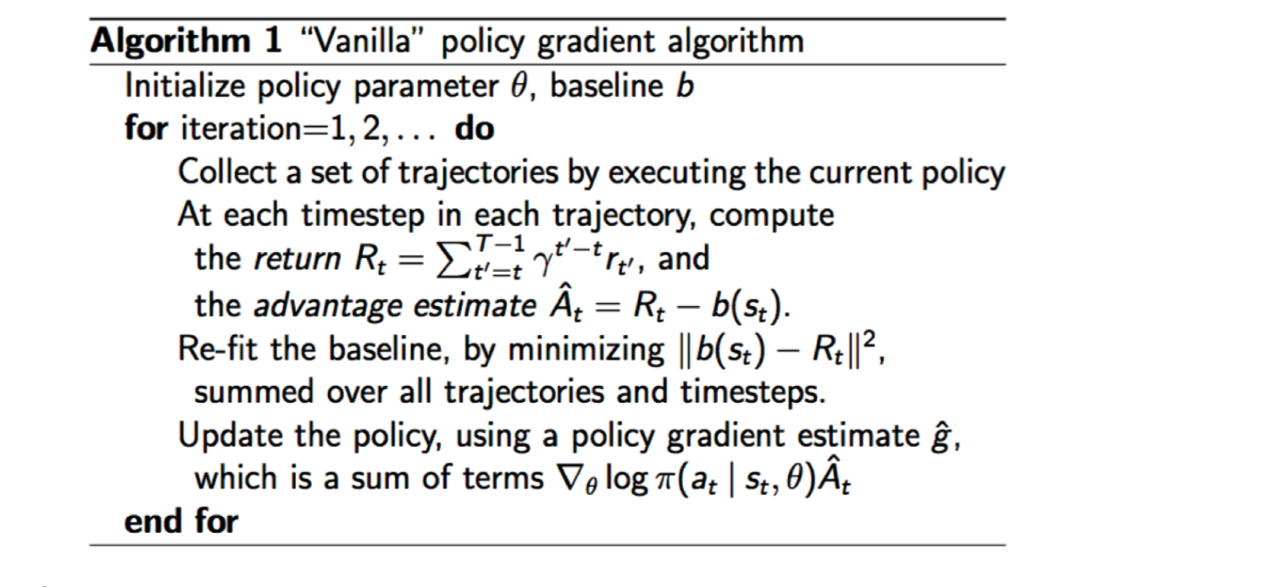

In [ ]:
from IPython import display
display.Image("images/pg.png", width = 600, height = 300)

---
### 3.2. Ejemplo de *Policy Gradient* con *Pytorch*

Información del entorno: https://www.gymlibrary.dev/environments/atari/breakout/

Basado en: https://github.com/keras-rl/keras-rl/blob/master/examples/dqn_atari.py

In [ ]:
import numpy as np
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.distributions import Bernoulli
from torch.autograd import Variable
from itertools import count

In [ ]:
# Define the model for our agent policy
class PolicyNet(nn.Module):
    def __init__(self):
        super(PolicyNet, self).__init__()

        self.fc1 = nn.Linear(4, 24)
        self.fc2 = nn.Linear(24, 36)
        self.fc3 = nn.Linear(36, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))

        return x

In [ ]:
# Plot duration curve
episode_durations = []

# Parameters
num_episode = 5000
batch_size = 5
learning_rate = 0.01
gamma = 0.99

env = gym.make('CartPole-v0')
policy_net = PolicyNet()
optimizer = torch.optim.RMSprop(policy_net.parameters(), lr=learning_rate)

# Batch History
state_pool = []
action_pool = []
reward_pool = []
steps = 0

In [ ]:
for e in range(num_episode):
    state = env.reset()
    state = torch.from_numpy(state).float()
    state = Variable(state)
    if not IN_COLAB:
      env.render(mode='rgb_array')

    for t in count():
        # Select the action following a probability distribution
        probs = policy_net(state)
        m = Bernoulli(probs)
        action = m.sample()

        action = action.data.numpy().astype(int)[0]

        next_state, reward, done, _ = env.step(action)
        if not IN_COLAB:
          env.render(mode='rgb_array')

        # To mark boundaries between episodes
        if done:
            reward = 0

        state_pool.append(state)
        action_pool.append(float(action))
        reward_pool.append(reward)

        state = next_state
        state = torch.from_numpy(state).float()
        state = Variable(state)

        steps += 1

        if done:
            episode_durations.append(t + 1)
            break

    # Update policy
    if e > 0 and e % batch_size == 0:

        # Discount reward
        running_add = 0
        for i in reversed(range(steps)):
            running_add = running_add * gamma + reward_pool[i]
            reward_pool[i] = running_add

        # Normalize reward
        reward_mean = np.mean(reward_pool)
        reward_std = np.std(reward_pool)
        for i in range(steps):
            reward_pool[i] = (reward_pool[i] - reward_mean) / reward_std

        # Gradient Descent
        optimizer.zero_grad()

        for i in range(steps):
            state = state_pool[i]
            action = Variable(torch.FloatTensor([action_pool[i]]))
            reward = reward_pool[i]

            probs = policy_net(state)
            m = Bernoulli(probs)
            loss = -m.log_prob(action) * reward  # Negative score function x reward
            loss.backward()

        optimizer.step()

        state_pool = []
        action_pool = []
        reward_pool = []
        steps = 0

---